In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp pascal_detection

# Pascal Darknet Detection
> Performing bounding box detection on PASCAL VOC 2007 using Darknet

In [ ]:
#| export
from minai import *

import torch
import torch.nn as nn
from torch import tensor
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision.transforms.v2.functional as TF
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.transforms import v2

from torcheval.metrics import MulticlassAccuracy

import fastcore.all as fc
from fastcore.utils import L
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from datasets import load_dataset, load_dataset_builder

from IPython.display import display, Image

from pilus_project.core import *
from pilus_project.darknet import *
from pilus_project.pascal_class import *

Using PyTorch transforms v2 [tutorial](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py) for bounding boxes.


In [ ]:
# Code from https://github.com/pytorch/vision/blob/main/gallery/transforms/helpers.py

import matplotlib.pyplot as plt
import torch
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [ ]:
from torchvision.utils import draw_bounding_boxes

In [ ]:
draw_bounding_boxes

<function torchvision.utils.draw_bounding_boxes(image: torch.Tensor, boxes: torch.Tensor, labels: Optional[List[str]] = None, colors: Union[List[Union[str, Tuple[int, int, int]]], str, Tuple[int, int, int], NoneType] = None, fill: Optional[bool] = False, width: int = 1, font: Optional[str] = None, font_size: Optional[int] = None) -> torch.Tensor>

## Data

### Data loading

In [ ]:
set_seed(42)

In [ ]:
data_path = fc.Path.home()/'data/'
data_path.ls()

(#3) [Path('/home/kappa/data/VOCtrainval_06-Nov-2007.tar'),Path('/home/kappa/data/VOCdevkit'),Path('/home/kappa/data/pili')]

In [ ]:
trn_ds, val_ds = create_voc_datasets(data_path)
trn_ds

Dataset VOCDetection
    Number of datapoints: 2501
    Root location: /home/kappa/data
    StandardTransform
Transform: Compose(
                 RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BILINEAR, antialias=True)
                 RandomHorizontalFlip(p=0.5)
                 ToImage()
                 ToDtype(scale=True)
                 Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
           )

In [ ]:
ds = datasets.VOCDetection(
    root=data_path, year="2007", image_set='train', download=False, )
#     target_transform=voc_extract(field='bndbox'))
ds[0]

(<PIL.Image.Image image mode=RGB size=500x333>,
 {'annotation': {'folder': 'VOC2007',
   'filename': '000012.jpg',
   'source': {'database': 'The VOC2007 Database',
    'annotation': 'PASCAL VOC2007',
    'image': 'flickr',
    'flickrid': '207539885'},
   'owner': {'flickrid': 'KevBow', 'name': '?'},
   'size': {'width': '500', 'height': '333', 'depth': '3'},
   'segmented': '0',
   'object': [{'name': 'car',
     'pose': 'Rear',
     'truncated': '0',
     'difficult': '0',
     'bndbox': {'xmin': '156', 'ymin': '97', 'xmax': '351', 'ymax': '270'}}]}})

## Dataset

In [ ]:
# to_tensor = v2.Compose([
#     v2.Resize((224, 224)),
#     v2.ToImage(),
#     v2.ToDtype(torch.float32, scale=True),
#     v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

In [ ]:
# trn_ds = datasets.VOCDetection(
#     root=data_path, year="2007", image_set='train', download=False, 
#     transform=to_tensor)
# val_ds = datasets.VOCDetection(
#     root=data_path, year="2007", image_set='val', download=False, 
#     transform=to_tensor)

In [ ]:
# bs = 64

# trn_dl, val_dl = get_dls(trn_ds, val_ds, bs=bs)
# xb,yb = next(iter(trn_dl))
# xb.shape,yb[:10]

### Extract Bounding Box Information

In [ ]:
def voc_extract_detection(targ, clss=VOC_CLASSES):
    "Extract class names and bounding boxes from VOC annotations"
    objects = fc.nested_attr(targ, 'annotation.object')
    if not objects: return [], []
    
    boxes = []
    labels = []
    for obj in objects:
        name = obj['name']
        if name in clss:
            bbox = obj['bndbox']
            x1, y1 = float(bbox['xmin']), float(bbox['ymin'])
            x2, y2 = float(bbox['xmax']), float(bbox['ymax'])
            boxes.append([x1, y1, x2, y2])
            labels.append(clss.index(name))
    
    return torch.tensor(boxes), torch.tensor(labels)

In [ ]:
x_trm = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
ds = datasets.VOCDetection(
    root=data_path, year="2007", image_set='train', download=False)
ds[0]

(<PIL.Image.Image image mode=RGB size=500x333>,
 {'annotation': {'folder': 'VOC2007',
   'filename': '000012.jpg',
   'source': {'database': 'The VOC2007 Database',
    'annotation': 'PASCAL VOC2007',
    'image': 'flickr',
    'flickrid': '207539885'},
   'owner': {'flickrid': 'KevBow', 'name': '?'},
   'size': {'width': '500', 'height': '333', 'depth': '3'},
   'segmented': '0',
   'object': [{'name': 'car',
     'pose': 'Rear',
     'truncated': '0',
     'difficult': '0',
     'bndbox': {'xmin': '156', 'ymin': '97', 'xmax': '351', 'ymax': '270'}}]}})

In [ ]:
sample_img, sample_target = ds[0]
boxes, labels = voc_extract_detection(sample_target)
boxes, labels

(tensor([[156.,  97., 351., 270.]]), tensor([6]))

In [ ]:
ds[0][0].size

(500, 333)

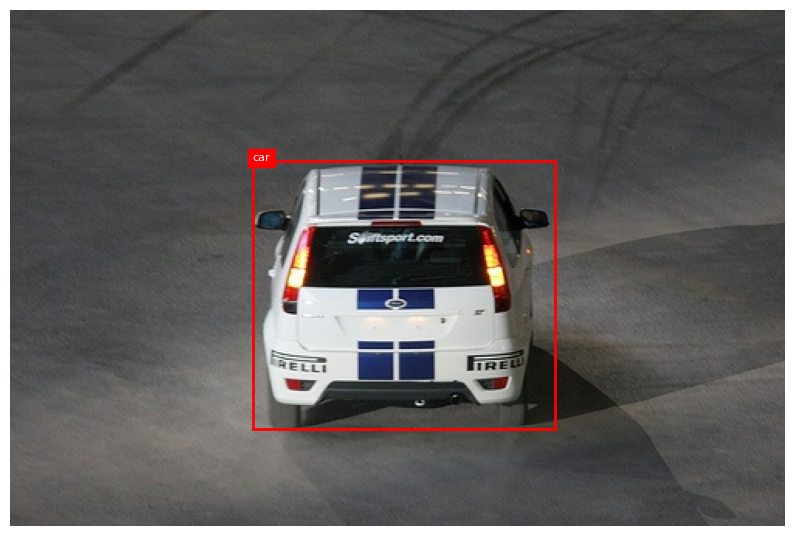

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(sample_img)
for box, label in zip(boxes, labels):
    x1, y1, x2, y2 = box.tolist()
    class_name = VOC_CLASSES[label]
    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
    plt.gca().add_patch(rect)
    plt.text(x1, y1, class_name, color='white', backgroundcolor='red', fontsize=8)
plt.axis('off');

More on [TVTensors](https://pytorch.org/vision/stable/auto_examples/transforms/plot_tv_tensors.html#sphx-glr-auto-examples-transforms-plot-tv-tensors-py).

In [ ]:
from torchvision import tv_tensors

boxes, labels = voc_extract_detection(sample_target)
boxes = tv_tensors.BoundingBoxes(
    boxes, format="XYXY", canvas_size=sample_img.size[::-1]) # PIL.Image returns (width, height) but we want (h,w)
boxes

BoundingBoxes([[156.,  97., 351., 270.]], format=BoundingBoxFormat.XYXY, canvas_size=(333, 500))

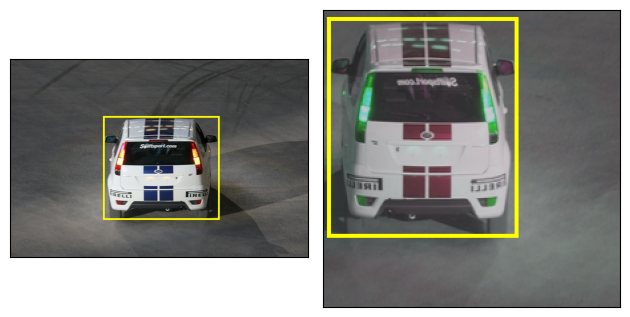

In [ ]:
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomPhotometricDistort(p=1),
    v2.RandomHorizontalFlip(p=1),
])
out_img, out_boxes = transforms(sample_img, boxes)
plot([(sample_img, boxes), (out_img, out_boxes)])

**Antialiasing**

Antialiasing helps prevent visual artifacts that occur when resizing images to smaller dimensions. When you downsample an image without antialiasing, high-frequency details can create jagged edges, moiré patterns, and other visual artifacts.

Here's what antialiasing does:

1. It applies a low-pass filter (typically a Gaussian blur) before downsampling to remove high-frequency components that would cause aliasing

2. This results in smoother transitions and reduced jagged edges in the resized image

3. It's particularly important when working with images containing fine details, text, or regular patterns

Setting `antialias=True` (the default in newer PyTorch versions) produces higher quality downsampled images but may be slightly slower. For most deep learning applications, using antialiasing is recommended because:

1. It provides more consistent and visually pleasing inputs to your model

2. It can reduce misleading high-frequency artifacts that might confuse the model

3. The small performance cost is usually negligible compared to the benefits in image quality

The only time you might want to disable it (`antialias=False`) is if:

1. You're extremely performance-sensitive and processing millions of images
2. You're trying to exactly reproduce results from older code that didn't use antialiasing
3. You specifically want to preserve certain high-frequency information for your particular task


### Another version

In [ ]:
from torchvision.datasets import wrap_dataset_for_transforms_v2

In [ ]:
ds = datasets.VOCDetection(
    root=data_path, year="2007", image_set='train', download=False, transforms=x_trm)
ds = wrap_dataset_for_transforms_v2(ds)
im, boxes = ds[0]
im, boxes

(Image([[[-0.9534, -0.9877, -0.9877,  ..., -1.1247, -1.1589, -1.2103],
         [-0.9534, -0.9877, -0.9877,  ..., -1.0562, -1.1075, -1.1418],
         [-0.9534, -0.9534, -0.9534,  ..., -1.0390, -1.0219, -1.0390],
         ...,
         [-0.8164, -0.7993, -0.7650,  ..., -0.6794, -0.7308, -0.7479],
         [-0.7650, -0.7650, -0.7308,  ..., -0.7137, -0.7137, -0.7137],
         [-0.7137, -0.7137, -0.7137,  ..., -0.7479, -0.7479, -0.7650]],
 
        [[-0.8452, -0.8803, -0.8803,  ..., -1.0203, -1.0378, -1.0728],
         [-0.8452, -0.8803, -0.8803,  ..., -0.9678, -0.9853, -1.0028],
         [-0.8452, -0.8452, -0.8452,  ..., -0.9503, -0.9153, -0.9153],
         ...,
         [-0.7227, -0.7227, -0.6877,  ..., -0.6176, -0.6176, -0.6352],
         [-0.6702, -0.6702, -0.6527,  ..., -0.6176, -0.6001, -0.6001],
         [-0.6176, -0.6176, -0.6352,  ..., -0.6527, -0.6352, -0.6527]],
 
        [[-0.6541, -0.6890, -0.6541,  ..., -0.7936, -0.8110, -0.8633],
         [-0.6541, -0.6715, -0.6541,  ..., 

By using TVTensors, boxes and labels are automatically retrieved!

In [ ]:
xstd[None,None,:]

tensor([[[0.2290, 0.2240, 0.2250]]])

In [ ]:
draw_bounding_boxes(im, boxes['boxes'])*xstd[:,None,None]

tensor([[[0.0108, 0.0036, 0.0036,  ..., 0.2021, 0.1940, 0.1823],
         [0.0108, 0.0036, 0.0036,  ..., 0.2173, 0.2057, 0.1976],
         [0.0108, 0.0108, 0.0108,  ..., 0.2218, 0.2254, 0.2218],
         ...,
         [0.0422, 0.0467, 0.0548,  ..., 0.0745, 0.0620, 0.0584],
         [0.0548, 0.0548, 0.0620,  ..., 0.0665, 0.0665, 0.0665],
         [0.0665, 0.0665, 0.0665,  ..., 0.0584, 0.0584, 0.0548]],

        [[0.0351, 0.0272, 0.0272,  ..., 0.2205, 0.2170, 0.2091],
         [0.0351, 0.0272, 0.0272,  ..., 0.0079, 0.0035, 0.0000],
         [0.0351, 0.0351, 0.0351,  ..., 0.0114, 0.0193, 0.0193],
         ...,
         [0.0624, 0.0624, 0.0703,  ..., 0.0861, 0.0861, 0.0826],
         [0.0747, 0.0747, 0.0782,  ..., 0.0861, 0.0905, 0.0905],
         [0.0861, 0.0861, 0.0826,  ..., 0.0782, 0.0826, 0.0782]],

        [[0.0785, 0.0706, 0.0785,  ..., 0.0468, 0.0432, 0.0318],
         [0.0785, 0.0750, 0.0785,  ..., 0.0591, 0.0547, 0.0468],
         [0.0785, 0.0829, 0.0865,  ..., 0.0626, 0.0706, 0.

In [ ]:
xstd

tensor([0.2290, 0.2240, 0.2250])

In [ ]:
def denorm(x): return (x*xstd[None,None,:]+xmean[None,None,:]).clip(0,1)

In [ ]:
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, tfm_x=fc.noop, tfm_y=fc.noop, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(tfm_x(im), **kwargs)
    if title is not None: ax.set_title(tfm_y(to_cpu(title)))
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    if noframe: ax.axis('off')
    return ax

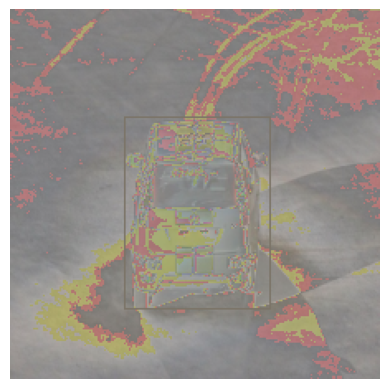

In [ ]:
box_im = draw_bounding_boxes(im, boxes['boxes'])
show_image(box_im, tfm_x=denorm);

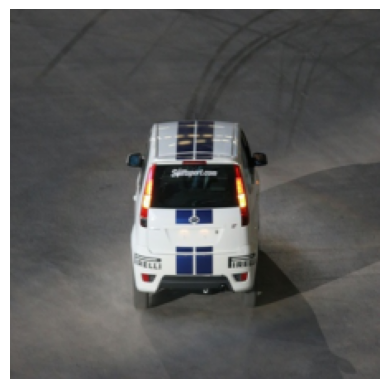

In [ ]:
show_image(im, tfm_x=denorm);

### Create a Detection Dataset

In [ ]:
class VOCDetectionDataset(Dataset):
    "Dataset for VOC object detection"
    def __init__(self, voc_ds, transforms=None):
        self.voc_ds = voc_ds
        self.transforms = transforms
        
    def __len__(self): return len(self.voc_ds)
    
    def __getitem__(self, idx):
        img, target = self.voc_ds[idx]
        boxes, labels = voc_extract_detection(target)
        
        # Handle empty boxes
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros(0, dtype=torch.int64)
        
        target = {"boxes": boxes, "labels": labels}
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
            
        return img, target

Sample target: {'boxes': tensor([[156.,  97., 351., 270.]]), 'labels': tensor([6])}


(-0.5, 499.5, 332.5, -0.5)

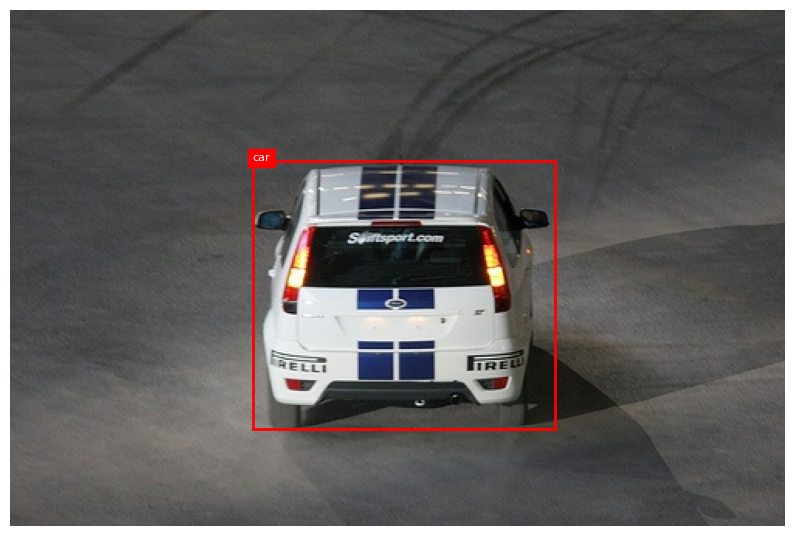

In [ ]:
# Create raw dataset
raw_ds = datasets.VOCDetection(root=data_path, year='2007', image_set='train', download=False)

# Create detection dataset
detection_ds = VOCDetectionDataset(raw_ds)

# Test with a sample
sample_img, sample_target = detection_ds[0]
print(f"Sample target: {sample_target}")

# Display the image with boxes
plt.figure(figsize=(10, 8))
plt.imshow(sample_img)
for box, label in zip(sample_target['boxes'], sample_target['labels']):
    x1, y1, x2, y2 = box.tolist()
    class_name = VOC_CLASSES[label]
    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
    plt.gca().add_patch(rect)
    plt.text(x1, y1, class_name, color='white', backgroundcolor='red', fontsize=8)
plt.axis('off')

### Create Transforms for Detection

In [ ]:
def get_detection_transforms(train=True):
    "Create transforms that correctly handle both images and bounding boxes"
    transforms_list = []
    
    # Convert PIL image to tensor and normalize
    transforms_list.extend([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True)
    ])
    
    if train:
        # Add augmentations for training only
        transforms_list.extend([
            v2.RandomPhotometricDistort(),
            v2.RandomZoomOut(fill=[0, 0, 0]),
            v2.RandomIoUCrop(),
            v2.RandomHorizontalFlip(p=0.5)
        ])
    
    # Add final resize and normalization
    transforms_list.extend([
        v2.Resize((800, 800)),  # Fixed size for simplicity
        v2.Normalize(mean=xmean, std=xstd)
    ])
    
    return v2.Compose(transforms_list)

In [ ]:
def show_boxes_before_after_transform(ds_raw, idx=0):
    "Show how bounding boxes are correctly transformed"
    # Create datasets with transforms
    train_transforms = get_detection_transforms(train=True)
    
    # Get raw sample
    img_raw, target_raw = ds_raw[idx]
    boxes_raw, labels_raw = voc_extract_detection(target_raw)
    
    # Create detection target format
    target_dict = {"boxes": boxes_raw, "labels": labels_raw}
    
    # Apply transforms
    img_transformed, target_transformed = train_transforms(img_raw, target_dict)
    
    # Plot before and after
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Before transform
    ax1.imshow(img_raw)
    ax1.set_title("Before Transform")
    for box, label in zip(boxes_raw, labels_raw):
        x1, y1, x2, y2 = box.tolist()
        class_name = VOC_CLASSES[label]
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
        ax1.add_patch(rect)
        ax1.text(x1, y1, class_name, color='white', backgroundcolor='red', fontsize=8)
    ax1.axis('off')
    
    # After transform
    img_display = denorm(img_transformed).permute(1, 2, 0).clip(0, 1).cpu().numpy()
    ax2.imshow(img_display)
    ax2.set_title("After Transform")
    for box, label in zip(target_transformed["boxes"], target_transformed["labels"]):
        x1, y1, x2, y2 = box.tolist()
        class_name = VOC_CLASSES[label]
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
        ax2.add_patch(rect)
        ax2.text(x1, y1, class_name, color='white', backgroundcolor='red', fontsize=8)
    ax2.axis('off')
    
    plt.tight_layout()
    return fig


In [ ]:
class VOCDetectionDataset(Dataset):
    "Dataset for VOC object detection with proper box transforms"
    def __init__(self, voc_ds, transforms=None):
        self.voc_ds = voc_ds
        self.transforms = transforms
        
    def __len__(self): return len(self.voc_ds)
    
    def __getitem__(self, idx):
        img, target = self.voc_ds[idx]
        boxes, labels = voc_extract_detection(target)
        
        # Handle empty boxes
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros(0, dtype=torch.int64)
        
        target = {"boxes": boxes, "labels": labels}
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
            
        return img, target

In [ ]:
def get_detection_dls(data_path, bs=4, year='2007'):
    "Create dataloaders for object detection with proper transforms"
    # Create raw datasets
    train_ds_raw = datasets.VOCDetection(root=data_path, year=year, image_set='train', download=False)
    valid_ds_raw = datasets.VOCDetection(root=data_path, year=year, image_set='val', download=False)
    
    # Create transforms
    train_transforms = get_detection_transforms(train=True)
    valid_transforms = get_detection_transforms(train=False)
    
    # Create detection datasets
    train_ds = VOCDetectionDataset(train_ds_raw, train_transforms)
    valid_ds = VOCDetectionDataset(valid_ds_raw, valid_transforms)
    
    # Create dataloaders
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, 
                         collate_fn=detection_collate_fn, num_workers=4)
    valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False, 
                         collate_fn=detection_collate_fn, num_workers=4)
    
    return DataLoaders(train_dl, valid_dl)

In [ ]:
# # Create raw dataset
# raw_ds = datasets.VOCDetection(root=data_path, year='2007', image_set='train', download=False)

# # Show before and after transforms
# show_boxes_before_after_transform(raw_ds, idx=5)

# # Create dataloaders with proper transforms
# detection_dls = get_detection_dls(data_path)

# # Visualize a batch to confirm boxes are aligned
# batch_imgs, batch_targets = next(iter(detection_dls.train))
# show_detection_batch(batch_imgs, batch_targets)

(-0.5, 719.5, 479.5, -0.5)

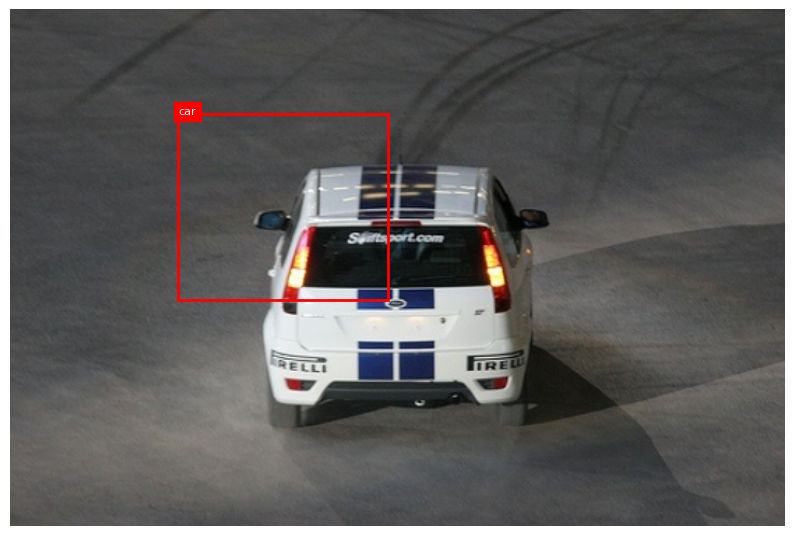

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(denorm(sample_img).permute(1, 2, 0).cpu().numpy())
for box, label in zip(sample_target['boxes'], sample_target['labels']):
    x1, y1, x2, y2 = box.tolist()
    class_name = VOC_CLASSES[label]
    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
    plt.gca().add_patch(rect)
    plt.text(x1, y1, class_name, color='white', backgroundcolor='red', fontsize=8)
plt.axis('off')

In [ ]:
def detection_collate_fn(batch):
    "Custom collate function for detection data with variable-sized boxes and labels"
    images = []
    targets = []
    
    for img, targ in batch:
        images.append(img)
        targets.append(targ)
    
    images = torch.stack(images)
    return images, targets

In [ ]:
# trn_dl, val_dl = get_detection_dls(data_path, bs=4)
# xb, yb = next(iter(trn_dl))
# show_detection_batch(xb, yb)

In [ ]:
def get_detection_dls(data_path, bs=8, year='2007'):
    "Create dataloaders for object detection"
    transforms = get_detection_transforms()
    
    train_ds = datasets.VOCDetection(root=data_path, year=year, image_set='train', download=False, transform=transforms)
    valid_ds = datasets.VOCDetection(root=data_path, year=year, image_set='val', download=False, transform=transforms)
    
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, collate_fn=detection_collate_fn, num_workers=4)
    valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False, collate_fn=detection_collate_fn, num_workers=4)
    
    return get_dls(train_dl, valid_dl, bs=bs)

In [ ]:
def show_detection_batch(images, targets, max_n=6, figsize=(15, 10)):
    "Show detection results with bounding boxes"
    n = min(len(images), max_n)
    fig, axs = plt.subplots(1, n, figsize=figsize)
    if n == 1: axs = [axs]
    
    for i in range(n):
        img = denorm(images[i])
        img = img.permute(1, 2, 0).cpu().numpy()
        ax = axs[i]
        ax.imshow(img)
        
        # Draw boxes
        for box, label in zip(targets[i]['boxes'], targets[i]['labels']):
            x1, y1, x2, y2 = box.tolist()
            class_name = VOC_CLASSES[label]
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
            ax.text(x1, y1, class_name, color='white', backgroundcolor='red', fontsize=8)
        
        ax.axis('off')
    
    plt.tight_layout()
    return fig

In [ ]:
def get_detection_model(num_classes=len(VOC_CLASSES) + 1):  # +1 for background
    "Create object detection model based on darknet19"
    from torchvision.models.detection import FasterRCNN
    from torchvision.models.detection.rpn import AnchorGenerator
    
    # Use darknet19 as backbone
    backbone = get_darknet19()
    
    # Remove the last layer (which is for classification)
    backbone = nn.Sequential(*list(backbone.children())[:-1])
    
    # FasterRCNN needs to know the number of output channels
    backbone.out_channels = 512
    
    # Define anchor generator
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )
    
    # Define ROI pooler
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )
    
    # Create the detection model
    model = FasterRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )
    
    return model

In [ ]:
# detection_dls = get_detection_dls(data_path, bs=4)  # Smaller batch size for detection

# # Visualize a batch
# xb, yb = next(iter(detection_dls.train))
# show_detection_batch(xb, yb)

In [ ]:
# # Create detection model
# detection_model = get_detection_model()

# # Detection models in torchvision handle the loss internally
# # So we need a custom learner that doesn't calculate loss separately
# class DetectionLearner(Learner):
#     def predict(self):
#         self.preds = self.model(self.batch[0])
    
#     def get_loss(self):
#         # Loss is already calculated inside the model during training
#         if self.training:
#             self.loss = sum(loss for loss in self.preds.values())
#         else:
#             self.loss = torch.tensor(0.0, device=self.batch[0].device)

# # Create learner
# learn = DetectionLearner(detection_model, detection_dls, None, lr=0.005,
#                        cbs=[DeviceCB(), ProgressCB()])

### Eval

In [ ]:
# Function to evaluate detection results
def evaluate_detection(model, dataloader, iou_threshold=0.5):
    "Evaluate detection model using mAP"
    from torchvision.ops import box_iou
    
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(def_device)
            predictions = model(images)
            
            # Move predictions to CPU
            for i in range(len(predictions)):
                pred = {k: v.cpu() for k, v in predictions[i].items()}
                all_preds.append(pred)
                all_targets.append(targets[i])
    
    # Calculate mAP
    # This is a simplified version - a full implementation would use the COCO API
    aps = []
    for class_idx in range(len(VOC_CLASSES)):
        precisions = []
        recalls = []
        
        for pred, target in zip(all_preds, all_targets):
            # Get predictions and targets for this class
            pred_boxes = pred['boxes'][pred['labels'] == class_idx]
            pred_scores = pred['scores'][pred['labels'] == class_idx]
            target_boxes = target['boxes'][target['labels'] == class_idx]
            
            if len(target_boxes) == 0:
                continue
                
            if len(pred_boxes) == 0:
                precisions.append(0)
                recalls.append(0)
                continue
            
            # Sort predictions by score
            sorted_idx = torch.argsort(pred_scores, descending=True)
            pred_boxes = pred_boxes[sorted_idx]
            
            # Calculate IoU
            ious = box_iou(pred_boxes, target_boxes)
            
            # Calculate precision and recall
            tp = (ious > iou_threshold).any(dim=1).float()
            fp = 1 - tp
            
            tp_cumsum = torch.cumsum(tp, dim=0)
            fp_cumsum = torch.cumsum(fp, dim=0)
            
            precision = tp_cumsum / (tp_cumsum + fp_cumsum)
            recall = tp_cumsum / len(target_boxes)
            
            precisions.append(precision)
            recalls.append(recall)
        
        # Calculate AP
        if precisions and recalls:
            # Simplified AP calculation
            ap = sum([p * r for p, r in zip(precisions, recalls)]) / len(precisions)
            aps.append(ap)
    
    return sum(aps) / len(aps) if aps else 0

# Evaluate the model
mAP = evaluate_detection(learn.model, detection_dls.valid)
print(f"mAP: {mAP:.4f}")

In [ ]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        padding = 1 if kernel_size == 3 else 0
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)

    def forward(self, x): return self.leaky(self.bn(self.conv(x)))

class Darknet19(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            # Initial layers
            ConvBlock(3, 32),
            nn.MaxPool2d(2),
            ConvBlock(32, 64),
            nn.MaxPool2d(2),
            
            # First block
            ConvBlock(64, 128),
            ConvBlock(128, 64, kernel_size=1),
            ConvBlock(64, 128),
            nn.MaxPool2d(2),
            
            # Second block
            ConvBlock(128, 256),
            ConvBlock(256, 128, kernel_size=1),
            ConvBlock(128, 256),
            nn.MaxPool2d(2),
            
            # Third block
            ConvBlock(256, 512),
            ConvBlock(512, 256, kernel_size=1),
            ConvBlock(256, 512),
            ConvBlock(512, 256, kernel_size=1),
            ConvBlock(256, 512),
            nn.MaxPool2d(2),
            
            # Fourth block
            ConvBlock(512, 1024),
            ConvBlock(1024, 512, kernel_size=1),
            ConvBlock(512, 1024),
            ConvBlock(1024, 512, kernel_size=1),
            ConvBlock(512, 1024)
        )

    def forward(self, x): return self.features(x)


In [ ]:
class YOLOv2(nn.Module):
    def __init__(self, num_classes, num_anchors=5):
        super().__init__()
        self.backbone = Darknet19()
        
        # Passthrough layer from earlier feature map
        self.passthrough_conv = ConvBlock(512, 64, kernel_size=1)
        
        # Detection head
        self.detection = nn.Sequential(
            ConvBlock(1024 + 256, 1024),  # +256 from passthrough (64*4)
            nn.Conv2d(1024, num_anchors * (5 + num_classes), kernel_size=1)
        )
        
    def reorg_layer(self, x):
        # Reorganize 26x26x64 to 13x13x256
        batch_size, channels, height, width = x.size()
        x = x.view(batch_size, channels, height//2, 2, width//2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.contiguous().view(batch_size, channels*4, height//2, width//2)
        return x

    def forward(self, x):
        # Get backbone features
        for i, layer in enumerate(self.backbone.features):
            x = layer(x)
            if i == 13:  # Save feature map for passthrough
                passthrough = self.passthrough_conv(x)
                passthrough = self.reorg_layer(passthrough)
        
        # Concatenate passthrough with final features
        x = torch.cat([passthrough, x], dim=1)
        
        # Detection head
        return self.detection(x)
